# Unit 3: Manipulation data - Groupby
---

1. [Working with dates](#section1)
2. [Simple Groupby](#section2)
3. [Sorting and filtering](#section3)
4. [Two or more attributes](#section4)
5. [Multiple aggregations](#section5)
6. [Tidy up](#section6)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Still with airport wildlife strikes. 
[Some more info on the data](https://github.com/nlihin/data-analytics/blob/main/datasets/aircraft%20wildlife%20strikes%20fieldlist.pdf)

This time data from 2018-2023. This dataset was too big to upload to Github, so I split it into two parts:\
2018-2020\
2021-2023

In [3]:
url1 = 'https://raw.githubusercontent.com/nlihin/data-analytics/main/datasets/aircraft%20wildlife%20strikes%202018-2020.csv'
url2 = 'https://raw.githubusercontent.com/nlihin/data-analytics/main/datasets/aircraft%20wildlife%20strikes%202021-2023.csv'
strike_df_18_20 = pd.read_csv(url1)
strike_df_21_23 = pd.read_csv(url2)

C:\Users\lihin\AppData\Local\Temp\ipykernel_25792\1453354056.py:3: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  strike_df_18_20 = pd.read_csv(url1)
C:\Users\lihin\AppData\Local\Temp\ipykernel_25792\1453354056.py:4: DtypeWarning: Columns (3,4,28) have mixed types. Specify dtype option on import or set low_memory=False.
  strike_df_21_23 = pd.read_csv(url2)


#### Combine the two files into one:
Since they have the same structure, `concat` can be used.
You will learn other options next year in DB course, but if you're curious, [look here](https://pandas.pydata.org/docs/user_guide/merging.html)

In [4]:
strike_df = pd.concat([strike_df_18_20 ,strike_df_21_23]).reset_index()

Note: `reset_index` is important here, or else you get the formar indices from both datasets (and then have multiple rows witht the same index)

### <span style="color:blue"> Exercise:</span>
> 
> How do you suggest to check that the files have been combined? (Sanity check)

<a id='section1'></a>
## 1. Working with dates

We have a cell that holds the dates:

In [ ]:
strike_df[['INCIDENT_DATE']].tail()

But it's currently of type object:

In [ ]:
strike_df[['INCIDENT_DATE']].dtypes

We will change 'INCIDENT_DATE' into a `datetime` object 

In [ ]:
strike_df['date'] = pd.to_datetime(strike_df['INCIDENT_DATE'],format='%d/%m/%Y')

Did it work?

In [ ]:
strike_df[['date']].dtypes

Extract the month:

In [ ]:
strike_df['month'] = pd.DatetimeIndex(strike_df['date']).month

In [ ]:
strike_df.loc[10:15,['date','month','struck_parts','SPECIES']]

You can use any combination [from here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

Another example:

In [ ]:
strike_df['year-month'] = pd.DatetimeIndex(strike_df['date']).strftime('%y-%m')
strike_df[["year-month",'date']].iloc[10:12]

### <span style="color:blue"> Exercise:</span>
> Extract the `year` and add it as a new column called `year` in `strike_df`
>
> Extract the name of the day and add it as a new column called `weekday` in `strike_df`
>
> Run the sanity check: `strike_df[["date","year","weekday"]]` 

In [12]:
# sanity check
#strike_df[["date","year","weekday"]]

<a id='section2'></a>
## 2. Simple groupby

[from pandas user guide:](https://pandas.pydata.org/docs/user_guide/groupby.html)\
By “group by” we are referring to a process involving one or more of the following steps:

* Splitting the data into groups based on some criteria.

* Applying a function to each group independently.

* Combining the results into a data structure.



The above split the data into groups\
Nothing happens here, since we didn't indicate what to do with each group\
But: no error. The split is valid :-)

Now lets perform a split and then an apply of an aggregation function

Count the number of species that are encountered each month:

In [ ]:
med_df = strike_df.groupby('month')[['SPECIES']].count() 
med_df

In [15]:
#med_df[["month"]]

Note that this format means `month` is now the index

this means `strike_df[["month"]]` won't work anymore

##### If you plan to continue using this data and need the index as an attribute:

##### add `reset_index()` and then assign

In [ ]:
med_df = med_df.reset_index()
med_df
#med_df[["location"]]

sum some data:

In [23]:
strike_df["people_impact"] = strike_df[['NR_INJURIES', 'NR_FATALITIES']].sum(axis=1)

### <span style="color:blue"> Exercise:</span>
> What is the total number of people impacted (the `people_impact`) in each month?
>
> What is the mean (average) of people impacted (the `people_impact`) each year?


Now let's see these on a graph:

<AxesSubplot: xlabel='year', ylabel='people_impact'>

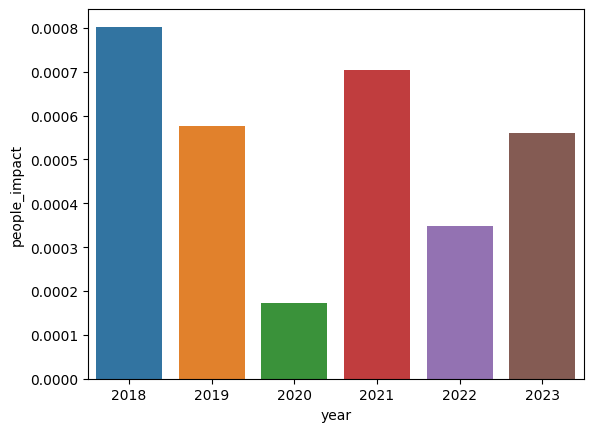

In [25]:
strike_df['year'] = pd.DatetimeIndex(strike_df['date']).year
sns.barplot(data=strike_df, y ='people_impact', x = 'year',errorbar=None)

<AxesSubplot: xlabel='month', ylabel='people_impact'>

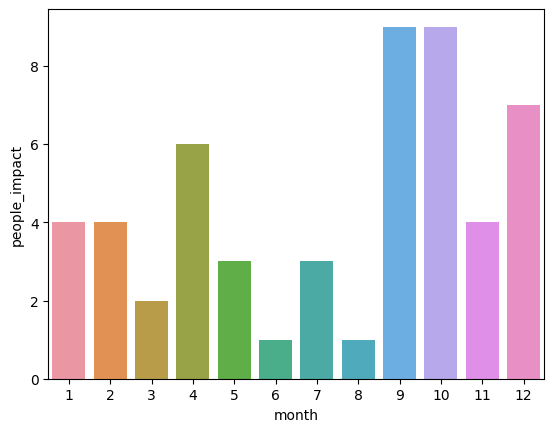

In [27]:
sns.barplot(data=strike_df, y ='people_impact', x = 'month', estimator = sum, errorbar=None)

<a id='section3'></a>
## 3. Sorting and filtering

Which bird species impacted people (by injuring or killing them)? How many cases were there?

In [ ]:
strike_df.groupby(['SPECIES'])[['people_impact']].sum()\
                                                 .reset_index()\
                                                 .sort_values(by="people_impact")

Most birds don't impact people. Filter out those who don't using `Filter`\
and then groupby again. You need to groupby twice:
* for the filter
* for the result after the filter

In [ ]:
bird_df = strike_df.groupby('SPECIES').filter(lambda x: x['people_impact'].sum() > 0) \
                            .groupby('SPECIES')[['people_impact']].sum() \
                            .reset_index() \
                            .sort_values(by="people_impact", ascending = False ) 
bird_df

another way to reach the same result, no filter:

In [187]:
bird_df = strike_df.groupby('SPECIES')[['people_impact']].sum() \
                            .reset_index() \
                            .sort_values(by="people_impact", ascending = False )\
                            .query('people_impact > 0')
bird_df

,SPECIES,people_impact
840,Unknown bird,9.0
833,Turkey vulture,4.0
179,Canada goose,3.0
684,Red-tailed hawk,3.0
53,Bald eagle,3.0
...,...,...
333,Fox sparrow,0.0
334,Fox sparrow,0.0
335,Foxes,0.0
336,Franklin's gull,0.0


We cannot plot this figure without performing the groupby (and some sort of filter) first:

In [ ]:
sns.barplot(data = bird_df.head(6), x = "SPECIES", y = "people_impact")
plt.xticks(rotation=45, ha='right')
plt.show()

<a id='section4'></a>
## 4. Groupby on two or more attributes

Now, groupby `month` and `year`

In [ ]:
strike_grpd = strike_df.groupby(['month','year'])[['people_impact', 'struck_parts']].sum().reset_index()
strike_grpd

### <span style="color:blue"> Exercise:</span>
> 
> 1. what will happen if we switch the order of the indexes: `['month', 'year']`?
>
> 2. Create a barplot for x="year", y="people_impact", alongside the lineplot (see the help below)

Some help with 2:

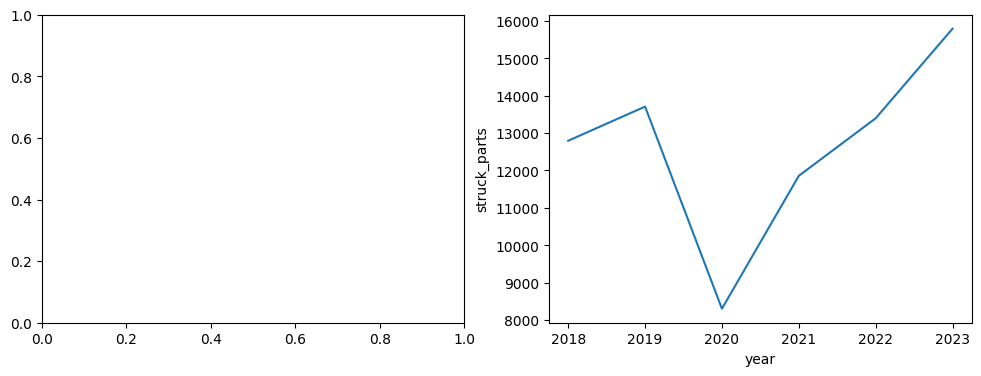

In [29]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
### INSERT YOUR CODE HERE
sns.lineplot(x="year", y="struck_parts",  data=strike_df,errorbar=None, estimator = sum, ax=axes[1])
plt.show()

<a id='section5'></a>
## 5. Multiple aggregations

In [ ]:
strike_group = strike_df.groupby('TIME_OF_DAY').\
agg({'people_impact': ['mean', 'median', 'max'], 'TIME_OF_DAY':['count'], 'AircraftOutOfService':['first', 'last', 'mean']})

strike_group = strike_group.reset_index()
strike_group

<a id='section6'></a>
## 6. Tidy your output

If you want to access the data and not deal with a multi-index, flatten the data by dropping a level and rename the columns:

In [ ]:
strike_group.columns

Each column currently has a multi-index, that is - several levels (two levels in our case).
We use [droplevel](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.droplevel.html) to remove one of the indexes.\
`droplevel(level, axis=0)`\
`level` - the position of the index to drop. The topmost or leftmost index is 0.\
`axis` - 0 removes a level in the columns, 1 removes a level in the rows.\
In our case, we have two rows of index, so `axis = 1`.

In [ ]:
strike_group = strike_group.droplevel(0, axis=1) 
strike_group

Rename the columns

In [ ]:
strike_group.columns = ['time of day','impact_mean','impact_median','impact_max','time_of_day_count','AOS_first','AOS_last','AOS_mean']
strike_group

# Summary:


---

>* `concat()` - combine dataframes with overlapping columns [documentation](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)
>
>* `dtypes` - returns the data type of a series (a column in a dataframe)
>
>* `pd.to_datetime(df['date'])` - changes the attribute type to datetime
>
>* `pd.DatetimeIndex(df['date']).month` - extracts the month from the datatime attribute
>
>*  `pd.DatetimeIndex(strike_df['date']).strftime('%y-%m-%w')` - create a string representing the time. use %y, %a, %A etc..  
>
>* `groupby()` - group according to the columns specified
>
>* `reset_index()`  adds a numerical index
>
>* `apply` - applies a function on each row (axis =0) in the dataframe. Change to (axis = 1) to apply the function on each column [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html#pandas.DataFrame.apply)
>
>* `lambda` - small anonymous function
>
>* `agg` - apply multiple functions at once, one for each specified column [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html)
>
>* `unstack` - unstack the inner-most index onto a column
>
>* `droplevel(0, axis = 1)` - drops the highest (first) level in the column index of a multi-index dataframe
>
>* `transpose` - switch between columns and rows
---

#### This was a lot of information.

#### Keep your balance. Practice. You will make it.

<div>
<img src="https://raw.githubusercontent.com/nlihin/data-analytics/main/images/balance.jpg" width="500"/>
</div>

Photo by <a href="https://unsplash.com/@martinsanchez?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Martin Sanchez</a> on <a href="https://unsplash.com/s/photos/perfect-balance?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  